# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
from torch import nn, optim 
import torch.nn.functional as F 
from collections import OrderedDict 
from PIL import Image
import numpy as np
import pandas as pd 


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# we will use these variables as the approriate file paths

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
# create data_transforms as a dictionary containing
# data transformed into appropriate tensors for training
# data transformed into appropriate tensors for validation 
# data transformed into appropriate tensors for testing 
# it's acertaining the color and shape/size of the pixels in the image 
# to justify a flower species recognition 
# they have to be correctly formatted tensors to work 
# convert it to a PyTorch tensor as it is loaded in as a pillow image
# this then becomes a 'pipeline' of transforms
# we will use matt's example from part 7 in terms of the numbers for the transforms themselves 
data_transforms = {
    'training_transform_set': transforms.Compose([transforms.RandomRotation(30),
                                                  transforms.RandomResizedCrop(224),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                                      [0.229, 0.224, 0.225])]),
    
    'validation_transform_set': transforms.Compose([transforms.Resize(255),
                                                   transforms.CenterCrop(224),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                                       [0.229, 0.224, 0.225])]),
    
    'testing_transform_set': transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])])}

# TODO: Load the datasets with ImageFolder
#use datasets imported from torchvision 
# dataset = datasets.ImageFolder('path/to/data', transform = transforms)
image_datasets = {'training': datasets.ImageFolder(train_dir, transform=data_transforms['training_transform_set']),
                 'validation': datasets.ImageFolder(valid_dir, transform=data_transforms['validation_transform_set']),
                 'testing': datasets.ImageFolder(test_dir, transform=data_transforms['testing_transform_set'])} 

# TODO: Using the image datasets and the trainforms, define the dataloaders
#once you have the dataset (with the file path and approriately transformed data)
# we have to pass it into a dataloader 
# we define a batch size, or the number of images you go through each 'batch' in this data loader
#  dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
# shuffle randomly shuffles the data every time you start a new ephoch, 2nd time different order, 3rd time also, etc
# this dataloader loads up a GENERATOR . very important concept 
dataloaders = {'train_loader':torch.utils.data.DataLoader(image_datasets['training'],batch_size=32,shuffle=True),
              'val_loader':torch.utils.data.DataLoader(image_datasets['validation'],batch_size=32,shuffle=True),
               'test_loader':torch.utils.data.DataLoader(image_datasets['testing'],batch_size=32,shuffle=True)}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [18]:
print(dataloaders['train_loader'])

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
#print(cat_to_name)

ModuleNotFoundError: No module named 'JsonLoader'

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# we want device agnostic code that will use the CUDA GPU if it is enabled 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# choose a pre trained network & load it
# we tried ResNet50 but only produced 40% accuracy
#trying other models
model = models.vgg16(pretrained=True)
model 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:14<00:00, 37379268.27it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
# load the model and turn off gradients
# freeze parameters so there is no backpropigation happening
# matt helped us with the logic of this in lesson 24 & 25
for param in model.parameters():
    param.requires_grad = False 

In [10]:
# define a new classifier using ReLu and dropout 
# we will follow matt's advice from section 8 in terms of the numerics
# we adjusted the weights in the classifier a few times
# to fine tune the model to produce above 70% accuracy in the validation and testing cycles
# we set our dropout to 0.5
classifier = nn.Sequential(nn.Linear(25088, 4096),
                          nn.ReLU(),
                          nn.Dropout(p=0.5), # was 0.2
                          nn.Linear(4096, 1024),
                          nn.ReLU(),
                          nn.Dropout(p=0.5), #was 0.2
                          nn.Linear(1024, 102), 
                          nn.LogSoftmax(dim=1))
# 777 the below code is for resnet
# model.fc = classifier #777
model.classifier = classifier 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
#next thing we want to do is define our loss
# set the learning rate to 0.001 
# now our model is set up well to preform the actual training 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) #was lr=0.003
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [ ]:
# TODO: Build and train your network

In [12]:
# defining the primary variables used in our training program
epochs = 20
steps = 0
running_loss = 0
print_every = 40

# build the 'training loop'
# this loop says, "this is how we learn from the data "
for epoch in range(epochs):
    # you can turn drop-out on, just to make sure . however it is immaterial 
    #model.train() #EDIT
    # we use the images formated into tensors from dataloaders['train_loader']
    for images, labels in dataloaders['train_loader']:
        #we take a step in our learning journey 
        steps += 1
        # move the tensor data over to the GPU so it can process everything even faster
        images, labels = images.to(device), labels.to(device)
        # zero out gradients
        optimizer.zero_grad()
        #obtain the log probabilities
        logps = model(images)
        #logps = model.forward(images)
        # now w/the log probabilities we can get the loss from the criterion in the labels
        loss = criterion(logps, labels)
        # do a backwards pass, or backpropigation so it can learn from it's own mistakes
        loss.backward()
        # now it learns one step forward, so we pass that as a forward step in the learning model
        # it's kind of like we are telling it how to think and learn from it's previous mistake
        #found in the backprop 
        optimizer.step()
        # finally we have to increment the running loss, so we keep track of of our total 'training loss'
        # and thus the program learns from itself continually 
        # until the end of it's cycle 
        running_loss += loss.item()
        
        #####VALIDATION LOOP ADDED
        
        if steps % print_every ==0:
            #turn our model into evaluation inference mode which turns off dropout
            # this allows using the network to make predictions
            model.eval() # turn off drop-out
            validation_loss = 0
            accuracy = 0
            # get the images and label tensors fro the testing set in dataloaders['test_loader']
            for images, labels in dataloaders['val_loader']:
                #transfer tensors over to the GPU
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                loss = criterion(logps, labels)
                validation_loss += loss.item()
                # calculate the accuracy
                ps = torch.exp(logps) # get probabilities
                top_ps, top_class = ps.topk(1, dim=1) # returns the 1st largest values in the probabilities 
                # check for equality by creating an equality tensor
                equality = top_class == labels.view(*top_class.shape)
                #calculate accuaracy from the equality 
                accuracy += torch.mean(equality.type(torch.FloatTensor))
        
                #we want to keep track of our epochs so we'll use the f string format
            print(f"Epoch {epoch+1}/{epochs}..."
                f"Train loss: {running_loss/print_every:.3f}..."
                f"Validation loss: {validation_loss/len(dataloaders['val_loader']):.3f}..."
                f"Validation accuracy: {accuracy/len(dataloaders['val_loader']):.3f}")
              
            running_loss = 0
            # Turn drop-out back on      
            model.train()
        
        

Epoch 1/20...Train loss: 4.801...Validation loss: 3.820...Validation accuracy: 0.190
Epoch 1/20...Train loss: 3.848...Validation loss: 2.803...Validation accuracy: 0.350
Epoch 1/20...Train loss: 3.326...Validation loss: 2.367...Validation accuracy: 0.408
Epoch 1/20...Train loss: 2.970...Validation loss: 1.855...Validation accuracy: 0.516
Epoch 1/20...Train loss: 2.833...Validation loss: 1.806...Validation accuracy: 0.556
Epoch 2/20...Train loss: 2.546...Validation loss: 1.529...Validation accuracy: 0.585
Epoch 2/20...Train loss: 2.505...Validation loss: 1.443...Validation accuracy: 0.613
Epoch 2/20...Train loss: 2.315...Validation loss: 1.248...Validation accuracy: 0.659
Epoch 2/20...Train loss: 2.461...Validation loss: 1.268...Validation accuracy: 0.668
Epoch 2/20...Train loss: 2.516...Validation loss: 1.303...Validation accuracy: 0.664
Epoch 3/20...Train loss: 2.411...Validation loss: 1.303...Validation accuracy: 0.661
Epoch 3/20...Train loss: 2.235...Validation loss: 1.163...Validat

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# TODO: Do validation on the test set
# testing for it's accuracy
#edit#if steps % print_every ==0:
    #turn our model into evaluation inference mode which turns off dropout
    # this allows using the network to make predictions
model.eval()
test_loss = 0
accuracy = 0
# get the images and label tensors fro the testing set in dataloaders['test_loader']
for images, labels in dataloaders['test_loader']:
    #transfer tensors over to the GPU
    images, labels = images.to(device), labels.to(device)
    logps = model(images)
    loss = criterion(logps, labels)
    test_loss += loss.item()
    # calculate the accuracy
    ps = torch.exp(logps) # get probabilities
    top_ps, top_class = ps.topk(1, dim=1) # returns the 1st largest values in the probabilities 
    # check for equality by creating an equality tensor
    equality = top_class == labels.view(*top_class.shape)
    #calculate accuaracy from the equality 
    accuracy += torch.mean(equality.type(torch.FloatTensor))
        
    #we want to keep track of our epochs so we'll use the f string format
    print(f"Test Loss: {test_loss/len(dataloaders['test_loader']):.3f}..."
          f"Test Accuracy: {accuracy/len(dataloaders['test_loader']):.3f}")
              
        #edit#this is meant for validation loop #running_loss = 0
        #edit#this is meant for validation loop #model.train()
# best result was around 12:03am at 44%      
# 1:10am runs at 41% accuracy    
# 2:36pm successful run at 0.409 or 41% (let's add layers to our network now)  
# 2:52pm , the added layer decreased accuracy from 41% to 27% (let's try changing dropout and/or learn-rate) 
# 3:03pm , chagning dropout from .2 to .5 decreased accuracy from 27% to 11% (0.105). let's change learn-rate  
# 3:11pm , changing learn-rate from .003 to .001 INCREASED accuracy from 11% to 38%. let's change our layers now
# increasing epoch to 20 and build the validation loop now 

Test Loss: 0.037...Test Accuracy: 0.026
Test Loss: 0.063...Test Accuracy: 0.058
Test Loss: 0.092...Test Accuracy: 0.091
Test Loss: 0.124...Test Accuracy: 0.120
Test Loss: 0.174...Test Accuracy: 0.148
Test Loss: 0.191...Test Accuracy: 0.183
Test Loss: 0.211...Test Accuracy: 0.218
Test Loss: 0.241...Test Accuracy: 0.248
Test Loss: 0.267...Test Accuracy: 0.280
Test Loss: 0.283...Test Accuracy: 0.314
Test Loss: 0.312...Test Accuracy: 0.346
Test Loss: 0.346...Test Accuracy: 0.377
Test Loss: 0.372...Test Accuracy: 0.410
Test Loss: 0.384...Test Accuracy: 0.445
Test Loss: 0.414...Test Accuracy: 0.477
Test Loss: 0.440...Test Accuracy: 0.510
Test Loss: 0.482...Test Accuracy: 0.540
Test Loss: 0.496...Test Accuracy: 0.576
Test Loss: 0.526...Test Accuracy: 0.605
Test Loss: 0.565...Test Accuracy: 0.636
Test Loss: 0.585...Test Accuracy: 0.671
Test Loss: 0.619...Test Accuracy: 0.701
Test Loss: 0.661...Test Accuracy: 0.732
Test Loss: 0.678...Test Accuracy: 0.767
Test Loss: 0.710...Test Accuracy: 0.797


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [14]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [15]:
torch.save(model, 'model_checkpoint.pth')

In [18]:
# TODO: Save the checkpoint 

#doing the below operation appears to save us huge headache in the future
# it saves a 'mapping of classes' to 'indices' that we get from one of the datasets
# it seems recommended to use the training set itself
#luckily the data is available as a generator as well
model.class_to_idx = image_datasets['training'].class_to_idx

#EXISTING MODEL IS GOOD. WANT TO SAVE. MAKE SURE THIS WILL SAVE MY WORK THUS FAR CORRECTLY BEFORE SAVING
# torch.save(model.state_dict(), 'sam_checkpoint.pth')
detailed_checkpoint = {'input_size': 25088,
             'output_size':102,
             'epochs':20,
             'learning_rate': 0.001,
             'optimizer_state': optimizer.state_dict(),
             'arch':"vgg16",
             'class_to_idx': model.class_to_idx,
             'hidden_layer1':4096,
             'hidden_layer2':1024,          
             'state_dict': model.state_dict()}
torch.save(detailed_checkpoint, 'detailed_checkpoint.pth')

In [ ]:
def sp_save_model(model, training_datasets, input_size, output_size, epochs, learning_rate, arch, hidden_layer1, hidden_layer2):
    
    model_checkpoint = torch.save(model, 'model_checkpoint1.pth')
    
    model.class_to_idx = image_datasets['training'].class_to_idx
    
    detailed_checkpoint = {'input_size': input_size,
             'output_size': output_size,
             'epochs': epochs,
             'learning_rate': learning_rate,
             'optimizer_state': optimizer.state_dict(),
             'arch': arch,
             'class_to_idx': model.class_to_idx,
             'hidden_layer1': hidden_layer1,
             'hidden_layer2': hidden_layer2,          
             'state_dict': model.state_dict()}
    
    detailed_checkpoint = torch.save(detailed_checkpoint, 'detailed_checkpoint1.pth')
    

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [6]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def simple_load_rebuild_model(path):
    trained_model = torch.load(path)
    return trained_model

In [19]:
# this was an original load function for the checkpoint
# I beielve I was making this task too difficult with the fc_model aspect
#as that did not even work correctly when run
# however the above function seems to be more concise and seems to works very well 


##def load_checkpoint(path):
##    checkpoint = torch.load(path)
##    model = fc_model.Network(checkpoint['input_size'],
##                             checkpoint['output_size'],
##                             checkpoint['epochs'],
##                             checkpoint['learning_rate'],
##                             checkpoint['optimizer'],
##                             checkpoint['class_to_idx'],
##                             checkpoint['hidden_layer1'],
##                             checkpoint['hidden_layer2'],
##                             checkpoint['state_dict'])
##    model.load_state_dict(checkpoint['state_dict'])
##    return model


# to rebuild the same model as the one we trained on
# using this fuction 
# do this
# modelM = load_checkpoint('detailed_checkpoint.pth')
# print(model)

In [11]:

# the output works great

In [ ]:
#lets test to see if we can load 
# torch.save(model, 'model_checkpoint.pth')   AND
# torch.save(detailed_checkpoint, 'detailed_checkpoint.pth')

In [7]:
rebuilt_model_checkpoint = simple_load_rebuild_model('model_checkpoint.pth')

In [8]:
rebuilt_model_checkpoint
# this works correctly
# so torch.save(model, 'model_checkpoint.pth')   captured the 'origin model'

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
rebuilt_detailed_checkpoint = simple_load_rebuild_model('detailed_checkpoint.pth')

In [10]:
rebuilt_detailed_checkpoint
## this ALSO works correctly
# so torch.save(model, 'detailed_checkpoint.pth')   captured the specific details in the 'state' of the model
# # this is important because the 'state' includes the state of tensors in operation 
# as well as the state of the optimizer
# this is especially important so we can use the model in the future
# don't forget the difference between your paths : 'model_checkpoint.pth'  VS  'detailed_checkpoint.pth'

{'input_size': 25088,
 'output_size': 102,
 'epochs': 20,
 'learning_rate': 0.001,
 'optimizer_state': {'state': {140453547107528: {'step': 4100,
    'exp_avg': tensor(1.00000e-02 *
           [[ 0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000,  0.0000],
            [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000, -0.0000],
            [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            ...,
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000]], device='cuda:0'),
    'exp_avg_sq': tensor(1.00000e-04 *
           [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            ...,
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.00

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [12]:
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model


    
    new_image = Image.open(image)#.convert("RGB")
    load_form = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    image_tensor = load_form(new_image).float() 
    return image_tensor
    
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:
# try running with a filename data as a test
# last save spot at 1:27am Sat 2/13

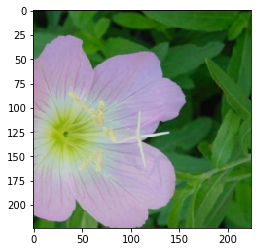

In [143]:

imshow(process_image('flowers/train/1/image_06734.jpg'))
imshow(process_image('flowers/train/1/image_06735.jpg'))
imshow(process_image('flowers/train/1/image_06736.jpg'))
imshow(process_image('flowers/train/1/image_06737.jpg'))

In [12]:
# an important lesson was learned by troublshooting the file path and TypeError
#the program expects either a numpy arrary OR pytorch tensor
# in this case, the pytorch tensor is expected in imshow
# pytorch tensor seems to be more overall mutable and usable than the base numpy array
#nevertheless we can easily convert from a numpy array into a pytorch tensor IF needed by 

#-->path = 'flowers/train/1/image_06734.jpg'
#-->processed_image = process_image(path)
#-->imshow(torch.from_numpy(processed_image))




#check = process_image('flowers/train/1/image_17744.jpg')
# no such file image_17744.jpg
# so it must be recognizing the above file in the above cell, image_06734.jpg
# however it is saying TypeError: 'tuple' object is not callable

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    #model input assumes the model has already been rebuilt using: simple_load_rebuild_model('xyz.pth')
    
    # you don't want to retrain right now so put in eval mode
    
    pic = process_image(image_path) #creates format of what was previously called 'test_image' from ee
    pic = pic.to(device)              
    pic = pic.unsqueeze(0)
    product = model.forward(pic)
    product = torch.exp(product)
    probs, classes = product.topk(topk, largest =True, sorted=True)
    probabilities = probs.data
    classes = classes.data
    probs_list = probabilities.tolist()
    classes_list = classes.tolist() 
    probs = probs_list[0]
    classes = classes_list[0]
    return probs, classes

In [15]:
probs, classes = predict('flowers/train/1/image_06736.jpg', rebuilt_model_checkpoint)

In [16]:
print(probs)
print(classes)

[0.48063910007476807, 0.16884948313236237, 0.10382959991693497, 0.08361651003360748, 0.0684858039021492]
[87, 0, 76, 30, 84]


In [136]:
# let's have as a goal to design this with
# as little code as possible
# so it is concise AND works well
# if there is a way we can leverage pytorch to do the heavy lifting for us
# that is what it's there for, right?



In [144]:
# let's have as a goal to design this with
# as little code as possible
# so it is concise AND works well
# if there is a way we can leverage pytorch to do the heavy lifting for us
# that is what it's there for, right?




tensor([[ 0.4806,  0.1688,  0.1038,  0.0836,  0.0685]], device='cuda:0')
tensor([[ 87,   0,  76,  30,  84]], device='cuda:0')


In [206]:
# this is with data from 
# process_image('flowers/train/1/image_06736.jpg')
print(probs.data)
print(classes.data)

tensor([[ 0.4806,  0.1688,  0.1038,  0.0836,  0.0685]], device='cuda:0')
tensor([[ 87,   0,  76,  30,  84]], device='cuda:0')


In [208]:
xx


[[0.48063910007476807,
  0.16884948313236237,
  0.10382959991693497,
  0.08361651003360748,
  0.0684858039021492]]

In [209]:
probabilities = xx[0]
probabilities 

[0.48063910007476807,
 0.16884948313236237,
 0.10382959991693497,
 0.08361651003360748,
 0.0684858039021492]

In [210]:
classes = yy[0]
classes

[87, 0, 76, 30, 84]

In [22]:
print(probs)
print(classes)

[0.48063910007476807, 0.16884948313236237, 0.10382959991693497, 0.08361651003360748, 0.0684858039021492]
[87, 0, 76, 30, 84]


In [23]:
probabilities = probs

In [24]:
p_c_dict = dict()
for idx in range(0, len(probabilities)):
    p_c_dict[classes[idx]] = probabilities[idx]
    
print(p_c_dict)

{87: 0.48063910007476807, 0: 0.16884948313236237, 76: 0.10382959991693497, 30: 0.08361651003360748, 84: 0.0684858039021492}


In [25]:
dict_origin_class2idx = rebuilt_detailed_checkpoint['class_to_idx']



In [26]:
dict_origin_class2idx = dict((value, key) for key,value in dict_origin_class2idx.items())


In [27]:
new_order_prob_class_dict = dict()
for key, values in dict_origin_class2idx.items():
    for k, v in p_c_dict.items():
        if str(key) == str(k):
            new_order_prob_class_dict[values]=v

new_order_prob_class_dict

{'1': 0.16884948313236237,
 '34': 0.08361651003360748,
 '76': 0.10382959991693497,
 '83': 0.0684858039021492,
 '86': 0.48063910007476807}

In [28]:
flower_prob_list = []
for key, value in new_order_prob_class_dict.items():
    flower_prob_dictionary = dict()
    for k, v in cat_to_name.items():
        if key == k:
            flower_prob_dictionary['name'] = v
            flower_prob_dictionary['prob'] = value
    flower_prob_list.append(flower_prob_dictionary)
    
flower_prob_list            

[{'name': 'pink primrose', 'prob': 0.16884948313236237},
 {'name': 'mexican aster', 'prob': 0.08361651003360748},
 {'name': 'morning glory', 'prob': 0.10382959991693497},
 {'name': 'hibiscus', 'prob': 0.0684858039021492},
 {'name': 'tree mallow', 'prob': 0.48063910007476807}]

In [29]:
dataframe = pd.DataFrame(flower_prob_list)
dataframe.head()

,name,prob
0,pink primrose,0.168849
1,mexican aster,0.083617
2,morning glory,0.103830
3,hibiscus,0.068486
4,tree mallow,0.480639


In [30]:
# sort the dataframe by probability 
dataframe = dataframe.sort_values(by=['prob'])
dataframe 

,name,prob
3,hibiscus,0.068486
1,mexican aster,0.083617
2,morning glory,0.103830
0,pink primrose,0.168849
4,tree mallow,0.480639


In [31]:
dataframe.iloc[-1]['name']

'tree mallow'

tree mallow


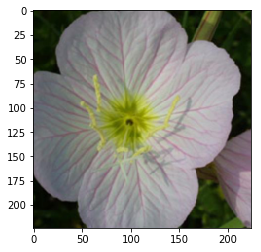

In [33]:
print(dataframe.iloc[-1]['name'])
imshow(process_image('flowers/train/1/image_06736.jpg'))

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

tree mallow


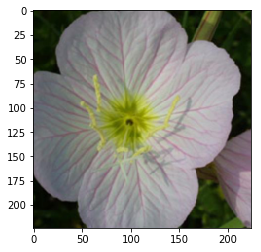

In [34]:
# TODO: Display an image along with the top 5 classes

print(dataframe.iloc[-1]['name'])
imshow(process_image('flowers/train/1/image_06736.jpg'))


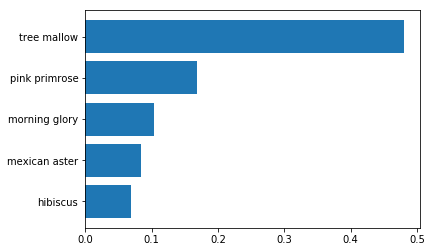

In [35]:
plt.barh(range(len(dataframe['name'])),dataframe['prob'])
plt.yticks(range(len(dataframe['name'])),dataframe['name'])
plt.show()

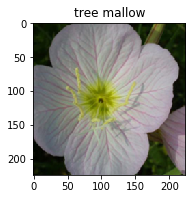

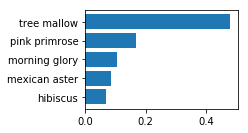

In [38]:
plt.figure(1)
plt.subplot(121)
plt.title(str(dataframe.iloc[-1]['name']))
imshow((process_image('flowers/train/1/image_06736.jpg')), plt, str(dataframe.iloc[-1]['name']))

plt.figure(2)
plt.subplot(222)

plt.barh(range(len(dataframe['name'])),dataframe['prob'])
plt.yticks(range(len(dataframe['name'])),dataframe['name'])
plt.show()

In [18]:
def sp_sanity_checker(cat_to_name, image_path, model_checkpoint, detailed_checkpoint):
    #you may need to include the entire predict funciton above this
    #use the model_checkpoint
    probs, classes = predict(image_path, model_checkpoint)
    
    #map key=classes to value=probabilities 
    p_c_dict = dict()
    for idx in range(0, len(probs)):
        p_c_dict[classes[idx]] = probs[idx]
        
    #build a dictionary including the class_to_idx from the model    
    dict_origin_class2idx = detailed_checkpoint['class_to_idx']
    dict_origin_class2idx = dict((value, key) for key,value in dict_origin_class2idx.items())

    #now map the flower IDnumber to the probability 
    new_order_prob_class_dict = dict()
    for key, values in dict_origin_class2idx.items():
        for k, v in p_c_dict.items():
            if str(key) == str(k):
                new_order_prob_class_dict[values]=v

    #now map the flower name to the probability 
    flower_prob_list = []
    for key, value in new_order_prob_class_dict.items():
        flower_prob_dictionary = dict()
        for k, v in cat_to_name.items():
            if key == k:
                flower_prob_dictionary['name'] = v
                flower_prob_dictionary['prob'] = value
        flower_prob_list.append(flower_prob_dictionary)
        
    #now create a simple pandas dataframe from flower_prob_list
    #so it can be easily mapped and plotted to matplotlib
    dataframe = pd.DataFrame(flower_prob_list)
    #sort from lowest to highest probability 
    dataframe = dataframe.sort_values(by=['prob'])
    
    #now plot the pic of the flower with it's name
    # and the approriated probabilities for the top 5 flowers
    plt.figure(1)
    plt.subplot(121)
    plt.title(str(dataframe.iloc[-1]['name']))
    imshow((process_image(image_path)), plt, str(dataframe.iloc[-1]['name']))

    plt.figure(2)
    plt.subplot(222)

    plt.barh(range(len(dataframe['name'])),dataframe['prob'])
    plt.yticks(range(len(dataframe['name'])),dataframe['name'])
    plt.show()

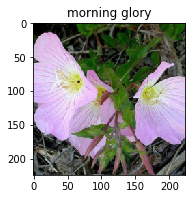

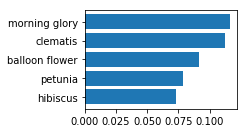

In [22]:
sp_sanity_checker(cat_to_name, 'flowers/train/1/image_06737.jpg', rebuilt_model_checkpoint, rebuilt_detailed_checkpoint)

2. Predict
Predict flower name from an image with predict.py along with the probability of that name. That is, you'll pass in a single image /path/to/image and return the flower name and class probability.

Basic usage: python predict.py /path/to/image checkpoint
Options:
Return top 
K
K most likely classes: python predict.py input checkpoint --top_k 3
Use a mapping of categories to real names: python predict.py input checkpoint --category_names cat_to_name.json
Use GPU for inference: python predict.py input checkpoint --gpu